# 參考網站 
+ [微軟的範例](https://github.com/microsoft/ML-For-Beginners/tree/main/7-TimeSeries/2-ARIMA)
+ [ARIMA-GARCH 模型(上)](https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/%E8%B3%87%E6%96%99%E7%A7%91%E5%AD%B8-%E5%8D%81-arima-garch%E6%A8%A1%E5%9E%8B-%E4%B8%8A-4cf07dac75fd)

# 參考網站 
+ [微軟的範例](https://github.com/microsoft/ML-For-Beginners/tree/main/7-TimeSeries/2-ARIMA)
+ [ARIMA-GARCH 模型(上)](https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/%E8%B3%87%E6%96%99%E7%A7%91%E5%AD%B8-%E5%8D%81-arima-garch%E6%A8%A1%E5%9E%8B-%E4%B8%8A-4cf07dac75fd)

# 參數設定

In [1]:
HORIZON = 1 # 0: 預設當日、1: 預測隔日(原本深度學習)，程式寫法僅支援 0,1

predict_types = [2,4,6]
fieldName = 'GroupCount'

# predict_types = [1]
# fieldName = 'GroupCount'

# training_window = @training_window@ # 過去天數，用於訓練資料中的歷史資料長度
# predict_type = @predict_type@
# fieldName = '@label_column@' 

# ==== 底下的參數基本上都不要亂動 ====
training_window = 14  # 過去天數，用於訓練資料中的歷史資料長度 
train_split_rate = 0.04  # 訓練集佔整體資料集的比例
# includeTraingData = False  # 資料來源是否包含訓練集最後 14 天，正常要包含，但有少數一些資料會有問題，若遇到有問題，把這個改成 False
 

actFiledName = fieldName 
if HORIZON == 1:
    actFiledName = f'{actFiledName}1'
    
model_dir = 'ARIMA/_Model'

# 定義類別

In [2]:
# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import ArimaLib 
importlib.reload(ArimaLib)   

from ArimaLib import * 
arima = ArimaLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
result_file_name = arima.reset_data(
    model_dir, 
    label_name = fieldName, 
    predicteds = predict_types
)

result_file_name: ARIMA/_Model/GroupCount_data246.result.json


# 載入數據

In [4]:
arima_data = arima.load_data(predict_types)[[fieldName]]
arima_data

# 載入數據


,GroupCount
RequestTime,
2023-04-02,1175
2023-04-03,1516
2023-04-04,1351
2023-04-05,1606
2023-04-06,3835
...,...
2024-04-26,2735
2024-04-27,2130
2024-04-28,2108


# 切割訓練和測試資料集

In [5]:
train_data, test_data = arima.split_train_test_data(arima_data, train_split_rate)
# train_data, test_data = arima.split_train_test_data2(arima_data, training_window=training_window)

# 切割訓練和測試資料集，split rate 0.04
這裡切割訓練和測試跟深度學習不同，這裡只是單純的要切割測試資料集區間，實際上並沒有用到訓練集
data length: 395
train_data.shape: (15, 1)
test_data.shape: (380, 1)


# 原始資料視覺化

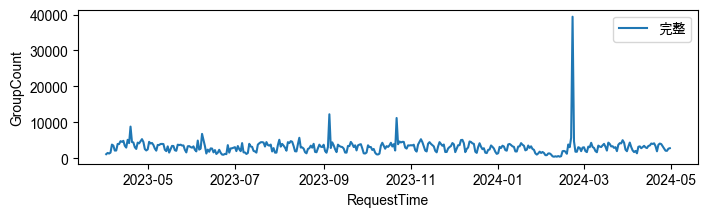

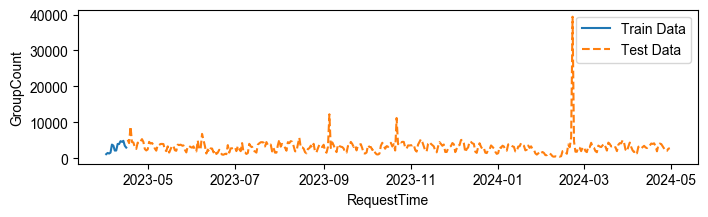

In [6]:
plt.figure(figsize=(8, 2))
plt.plot(arima_data.index, arima_data[fieldName], label='完整')

plt.xlabel('RequestTime')
plt.ylabel(fieldName)
plt.legend()
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(train_data.index, train_data[fieldName], label='Train Data')
plt.plot(test_data.index, test_data[fieldName], label='Test Data', linestyle='--')

plt.xlabel('RequestTime')
plt.ylabel(fieldName)
plt.legend()
plt.show()

# 找出最佳參數

In [7]:
# if includeTraingData:
#     print(f'使用訓練集前 {training_window} 天')
#     aic_data = [x for x in train_data[fieldName]]
#     aic_data = aic_data[(-training_window):] 
#     aic_data.extend(test_data[fieldName].values) 
# else:
#     print(f'不使用訓練集前 {training_window} 天')
#     aic_data = test_data[fieldName].values

aic_data = arima_data[fieldName].values
print(len(aic_data))

auto_model, best_p, best_d, best_q, best_aic, arima_resid, best_ar_pvalue, best_ma_pvalue = \
    arima.find_best_config(aic_data, window_size=training_window)
# 基本上選出來的 P-Vaule 都要小於 0.05，才達到顯著的效果，代表是平穩的序列

395
# 找到最佳的 p, d, q 值，window_size: 14 



Best model:  ARIMA(13,0,6)(0,0,0)[0]          
Total fit time: 34.201 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  395
Model:              SARIMAX(13, 0, 6)   Log Likelihood               -3595.330
Date:                Thu, 19 Jun 2025   AIC                           7230.660
Time:                        11:10:32   BIC                           7310.238
Sample:                             0   HQIC                          7262.190
                                - 395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2044      0.521     -0.392      0.695      -1.226       0.817
ar.L2          1.1274      0.402      2.803      0.0

# 使用 ARMIA 套件再次驗證

In [8]:
model_summary_fit = arima.check_arima_model(aic_data, best_p, best_d, best_q)

# 檢查 ARIMA 模型


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  395
Model:                ARIMA(13, 0, 6)   Log Likelihood               -3585.710
Date:                Thu, 19 Jun 2025   AIC                           7213.419
Time:                        11:10:33   BIC                           7296.976
Sample:                             0   HQIC                          7246.525
                                - 395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3156.9769    281.609     11.211      0.000    2605.034    3708.919
ar.L1         -0.1887      1.058     -0.178      0.858      -2.263       1.885
ar.L2          1.0725      0.828      1.296      0.1

# Shift 預測資料

In [9]:
test_shifted = arima.shift_data(test_data, fieldName, HORIZON)
test_shifted.head()
print(len(test_shifted))

# 整理預測未來的資料
380


# 執行預測

In [10]:
test_ts, predictions = arima.predict(
    train_data, test_shifted, 
    field_name=fieldName, 
    act_field_name=actFiledName,
    best_d=best_d,
    best_p=best_p,
    best_q=best_q,
    training_window=training_window,
    horizon=HORIZON
)

# 開始預測
第一個預測日 :  2023-04-17 00:00:00
第一個預測日，前 {training_window} 日數據 :               GroupCount
RequestTime            
2023-04-03         1516
2023-04-04         1351
2023-04-05         1606
2023-04-06         3835
2023-04-07         3561
2023-04-08         2179
2023-04-09         2191
2023-04-10         4012
2023-04-11         3989
2023-04-12         4790
2023-04-13         4615
2023-04-14         4882
2023-04-15         3509
2023-04-16         3005
第一個預測日當日 :  5168.0
第一個預測日隔日 :  4245.0
第一個預測日，前 {training_window} 日數據 :  [1175, 1516, 1351, 1606, 3835, 3561, 2179, 2191, 4012, 3989, 4790, 4615, 4882, 3509, 3005]
最佳的 p 值: 13
最佳的 d 值: 0
最佳的 q 值: 6
-------------------------------------------------------
-------------------------------------------------------



/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


yhat: [-10512.31741469 143435.44543746]
( 0). 實際 : 4245.0 預測 : 143435.44543745636 差距 : -139190.44543745636
yhat: [-27292.95480329 189781.13124392]
( 1). 實際 : 8843.0 預測 : 189781.13124392208 差距 : -180938.13124392208


yhat: [-55220.14701479  32417.51887877]
( 2). 實際 : 4557.0 預測 : 32417.51887877381 差距 : -27860.51887877381
yhat: [-4505.82364344 15732.88356652]
( 3). 實際 : 4428.0 預測 : 15732.883566521607 差距 : -11304.883566521607


yhat: [6316.74226044 1450.6287593 ]
( 4). 實際 : 3100.0 預測 : 1450.6287593034767 差距 : 1649.3712406965233
yhat: [1976.42681367  114.22600817]
( 5). 實際 : 2634.0 預測 : 114.22600816775594 差距 : 2519.773991832244


yhat: [  165.92517971 10360.62447661]
( 6). 實際 : 4393.0 預測 : 10360.624476605284 差距 : -5967.624476605284
yhat: [9660.56480698 3589.40975288]
( 7). 實際 : 4177.0 預測 : 3589.40975288239 差距 : 587.59024711761


yhat: [9203.2776068  9395.18532932]
( 8). 實際 : 4762.0 預測 : 9395.185329318965 差距 : -4633.185329318965
yhat: [16083.70643828 -6524.32373337]
( 9). 實際 : 5352.0 預測 : -6524.323733369802 差距 : 11876.323733369802


yhat: [ 1474.27336652 -3441.72348365]
(10). 實際 : 4564.0 預測 : -3441.723483647909 差距 : 8005.723483647909
yhat: [-5897.75875357  1565.98055658]
(11). 實際 : 2599.0 預測 : 1565.9805565830488 差距 : 1033.0194434169512


yhat: [-3406.52023842  9679.64062262]
(12). 實際 : 2210.0 預測 : 9679.640622616263 差距 : -7469.6406226162635
yhat: [4396.52360953  972.53587279]
(13). 實際 : 2492.0 預測 : 972.5358727933631 差距 : 1519.464127206637


yhat: [-2723.82992214  3574.34449889]
(14). 實際 : 4600.0 預測 : 3574.3444988892365 差距 : 1025.6555011107635
yhat: [4227.14857889 5929.30031063]
(15). 實際 : 4140.0 預測 : 5929.3003106341785 差距 : -1789.3003106341785


yhat: [7184.34684539 1502.283662  ]
(16). 實際 : 4289.0 預測 : 1502.2836620035073 差距 : 2786.7163379964927
yhat: [4962.79201864 1472.4898948 ]
(17). 實際 : 3725.0 預測 : 1472.4898948023265 差距 : 2252.5101051976735


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


yhat: [3048.73759621 3694.45147453]
(18). 實際 : 2732.0 預測 : 3694.451474528933 差距 : -962.451474528933
yhat: [2288.34119845 3894.01929665]
(19). 實際 : 2154.0 預測 : 3894.0192966452296 差距 : -1740.0192966452296


yhat: [  423.80172553 -7279.63788917]
(20). 實際 : 3736.0 預測 : -7279.637889172625 差距 : 11015.637889172625
yhat: [-6096.35212991 -5405.11095975]
(21). 實際 : 3718.0 預測 : -5405.110959748696 差距 : 9123.110959748696


yhat: [-1802.98595681  8878.29195716]
(22). 實際 : 4004.0 預測 : 8878.291957158654 差距 : -4874.2919571586535
yhat: [5160.80821119 1856.71845698]
(23). 實際 : 4029.0 預測 : 1856.718456980696 差距 : 2172.281543019304


yhat: [4084.784671   2566.43530654]
(24). 實際 : 3983.0 預測 : 2566.435306535047 差距 : 1416.564693464953
yhat: [2782.67825817 3094.54210858]
(25). 實際 : 2403.0 預測 : 3094.5421085835223 差距 : -691.5421085835223


yhat: [3027.47866767 2195.58014145]
(26). 實際 : 2020.0 預測 : 2195.5801414467624 差距 : -175.58014144676235
yhat: [2205.13562575 3424.88282971]
(27). 實際 : 3347.0 預測 : 3424.882829706788 差距 : -77.88282970678802


yhat: [3231.2307697  3920.02037136]
(28). 實際 : 1619.0 預測 : 3920.020371357168 差距 : -2301.020371357168
yhat: [3849.08108682 4908.42873145]
(29). 實際 : 2528.0 預測 : 4908.428731447767 差距 : -2380.428731447767


yhat: [4592.76304658 4762.38722245]
(30). 實際 : 3470.0 預測 : 4762.387222447296 差距 : -1292.3872224472962
yhat: [4304.96227988 4467.91318465]
(31). 實際 : 3444.0 預測 : 4467.913184654604 差距 : -1023.9131846546043


yhat: [3968.46055788 3773.50924726]
(32). 實際 : 2261.0 預測 : 3773.509247258965 差距 : -1512.509247258965
yhat: [3702.49616531 3418.83617253]
(33). 實際 : 2110.0 預測 : 3418.8361725314803 差距 : -1308.8361725314803


yhat: [3008.59583454 2846.41502599]
(34). 實際 : 3815.0 預測 : 2846.415025990535 差距 : 968.584974009465
yhat: [2409.20502979 2672.91598488]
(35). 實際 : 3700.0 預測 : 2672.915984881202 差距 : 1027.084015118798


yhat: [2465.41367373 2967.11697814]
(36). 實際 : 3822.0 預測 : 2967.1169781410126 差距 : 854.8830218589874
yhat: [2951.06841934 4220.823186  ]
(37). 實際 : 3574.0 預測 : 4220.823186004 差距 : -646.8231860039996


yhat: [4337.52443823 3741.757677  ]
(38). 實際 : 3607.0 預測 : 3741.7576770046912 差距 : -134.75767700469123
yhat: [3281.265267   2786.39605002]
(39). 實際 : 2373.0 預測 : 2786.3960500209273 差距 : -413.3960500209273


yhat: [2229.57179608 3161.61700181]
(40). 實際 : 1664.0 預測 : 3161.617001811911 差距 : -1497.617001811911
yhat: [2849.82852328 4357.50475844]
(41). 實際 : 3360.0 預測 : 4357.504758443492 差距 : -997.5047584434924


yhat: [4354.82485876 3130.78215458]
(42). 實際 : 3420.0 預測 : 3130.7821545760416 差距 : 289.21784542395835
yhat: [3068.09304802 3038.60771407]
(43). 實際 : 3143.0 預測 : 3038.6077140741063 差距 : 104.3922859258937


yhat: [3091.23254709 4831.71784894]
(44). 實際 : 2985.0 預測 : 4831.717848937315 差距 : -1846.7178489373146
yhat: [4838.32937593 4421.75124872]
(45). 實際 : 3348.0 預測 : 4421.751248721381 差距 : -1073.7512487213808


yhat: [4080.01395003 1779.46083649]
(46). 實際 : 2380.0 預測 : 1779.460836490939 差距 : 600.5391635090609
yhat: [1758.00026532 2030.75082608]
(47). 實際 : 1951.0 預測 : 2030.7508260763009 差距 : -79.75082607630088


yhat: [2362.61894536 4294.08442606]
(48). 實際 : 4956.0 預測 : 4294.084426063711 差距 : 661.9155739362886


yhat: [4115.5684397  3977.98977829]
(49). 實際 : 2450.0 預測 : 3977.989778290804 差距 : -1527.9897782908042


yhat: [4365.2379484 2869.0248104]
(50). 實際 : 2712.0 預測 : 2869.0248104017837 差距 : -157.02481040178372


yhat: [2750.7437586  3424.15148038]
(51). 實際 : 6810.0 預測 : 3424.1514803769305 差距 : 3385.8485196230695


yhat: [3319.52311904 3929.60298233]
(52). 實際 : 5094.0 預測 : 3929.602982333235 差距 : 1164.397017666765


yhat: [3737.59699019 2332.05333794]
(53). 實際 : 3428.0 預測 : 2332.0533379420594 差距 : 1095.9466620579406


yhat: [2863.35876003 3607.70673999]
(54). 實際 : 1356.0 預測 : 3607.7067399862026 差距 : -2251.7067399862026


yhat: [3400.27737827 5238.85468158]
(55). 實際 : 2442.0 預測 : 5238.854681581275 差距 : -2796.854681581275


yhat: [5115.72992796 3899.21727617]
(56). 實際 : 1849.0 預測 : 3899.2172761747483 差距 : -2050.2172761747483


yhat: [3569.46242371 3513.20388069]
(57). 實際 : 2776.0 預測 : 3513.203880690177 差距 : -737.2038806901769


yhat: [3726.39429808 5392.38918716]
(58). 實際 : 2736.0 預測 : 5392.389187162873 差距 : -2656.389187162873


yhat: [5612.29640078 4219.35838064]
(59). 實際 : 1677.0 預測 : 4219.358380644924 差距 : -2542.358380644924


yhat: [4444.15459616 3414.43487231]
(60). 實際 : 2309.0 預測 : 3414.4348723107087 差距 : -1105.4348723107087


yhat: [  8520.75158515 -15923.06518772]
(61). 實際 : 1237.0 預測 : -15923.065187721024 差距 : 17160.065187721026


yhat: [5356.65054511 2339.33843922]
(62). 實際 : 1594.0 預測 : 2339.338439221659 差距 : -745.338439221659


yhat: [5608.78583273  649.79046024]
(63). 實際 : 2390.0 預測 : 649.7904602375552 差距 : 1740.2095397624448


yhat: [5188.8496103   893.93884387]
(64). 實際 : 1564.0 預測 : 893.9388438722144 差距 : 670.0611561277856


yhat: [  11754.19758657 -104923.45698881]
(65). 實際 : 1060.0 預測 : -104923.45698881266 差距 : 105983.45698881266


yhat: [ 8229.66725979 -1832.25381938]
(66). 實際 : 1019.0 預測 : -1832.253819376484 差距 : 2851.253819376484


yhat: [6468.92259188 3889.55266234]
(67). 實際 : 1257.0 預測 : 3889.5526623389437 差距 : -2632.5526623389437


yhat: [2597.37328706 1621.75007335]
(68). 實際 : 1179.0 預測 : 1621.7500733513916 差距 : -442.7500733513916


yhat: [1728.26949277 1310.84601735]
(69). 實際 : 3697.0 預測 : 1310.8460173509905 差距 : 2386.15398264901


yhat: [1712.87518367 2611.79546599]
(70). 實際 : 1604.0 預測 : 2611.7954659918732 差距 : -1007.7954659918732


yhat: [2827.21825035 4486.87317865]
(71). 實際 : 2765.0 預測 : 4486.8731786471435 差距 : -1721.8731786471435


yhat: [2189.12020676 3536.27085506]
(72). 實際 : 2821.0 預測 : 3536.2708550632174 差距 : -715.2708550632174


yhat: [2894.77567035 2592.61050982]
(73). 實際 : 2960.0 預測 : 2592.610509816879 差距 : 367.38949018312087


yhat: [2307.42723283 3353.59394352]
(74). 實際 : 3123.0 預測 : 3353.5939435245273 差距 : -230.59394352452728


yhat: [2887.8035321  2310.29166541]
(75). 實際 : 2024.0 預測 : 2310.291665408797 差距 : -286.29166540879714


yhat: [2225.22897798 4182.63727632]
(76). 實際 : 3437.0 預測 : 4182.637276319234 差距 : -745.6372763192339


yhat: [4153.52702944 3743.23662919]
(77). 實際 : 2560.0 預測 : 3743.236629193993 差距 : -1183.236629193993


yhat: [3567.7066429  3819.19117397]
(78). 實際 : 2009.0 預測 : 3819.1911739721536 差距 : -1810.1911739721536


yhat: [3511.41348932 2671.44895629]
(79). 實際 : 4249.0 預測 : 2671.448956287348 差距 : 1577.5510437126518


yhat: [2265.77311763 3082.62509992]
(80). 實際 : 1679.0 預測 : 3082.6250999221606 差距 : -1403.6250999221606


yhat: [3957.92943259 4246.62278489]
(81). 實際 : 1655.0 預測 : 4246.622784893286 差距 : -2591.622784893286


yhat: [3426.57019219 3103.50341532]
(82). 實際 : 1236.0 預測 : 3103.5034153157235 差距 : -1867.5034153157235


yhat: [2677.89263337 2326.16515135]
(83). 實際 : 1502.0 預測 : 2326.165151345073 差距 : -824.1651513450729


yhat: [2030.83000703 2637.55171814]
(84). 實際 : 4055.0 預測 : 2637.551718141277 差距 : 1417.448281858723


yhat: [2305.43114393 2215.5483583 ]
(85). 實際 : 3323.0 預測 : 2215.548358303193 差距 : 1107.4516416968072


yhat: [3280.52835886 4257.20373737]
(86). 實際 : 3208.0 預測 : 4257.203737374537 差距 : -1049.203737374537


yhat: [3750.22673735 3270.45800148]
(87). 實際 : 2084.0 預測 : 3270.4580014810876 差距 : -1186.4580014810876


yhat: [2779.48802331 2775.01891831]
(88). 實際 : 1933.0 預測 : 2775.0189183056063 差距 : -842.0189183056063


yhat: [2880.89438394 3094.79836477]
(89). 實際 : 1606.0 預測 : 3094.7983647651636 差距 : -1488.7983647651636


yhat: [2848.97433448 2658.04644441]
(90). 實際 : 3829.0 預測 : 2658.046444408497 差距 : 1170.9535555915031


yhat: [2215.83553314 2733.50140046]
(91). 實際 : 4194.0 預測 : 2733.501400459099 差距 : 1460.498599540901


yhat: [3276.86081033 3740.67551979]
(92). 實際 : 4485.0 預測 : 3740.6755197864904 差距 : 744.3244802135096


yhat: [3752.55216324 3598.91724047]
(93). 實際 : 4516.0 預測 : 3598.9172404656306 差距 : 917.0827595343694


yhat: [3936.68242434 3260.38334965]
(94). 實際 : 4405.0 預測 : 3260.383349649584 差距 : 1144.616650350416


yhat: [3637.82387888 2571.63643903]
(95). 實際 : 3305.0 預測 : 2571.6364390254234 差距 : 733.3635609745766


yhat: [3193.523789   3267.12758579]
(96). 實際 : 4532.0 預測 : 3267.127585791433 差距 : 1264.872414208567


yhat: [3141.80120411 3303.5443058 ]
(97). 實際 : 3714.0 預測 : 3303.5443058038672 差距 : 410.45569419613275


yhat: [4213.19010382 4286.826726  ]
(98). 實際 : 3552.0 預測 : 4286.826725999677 差距 : -734.8267259996774


yhat: [4269.77466851 4665.98137167]
(99). 實際 : 3838.0 預測 : 4665.981371671976 差距 : -827.9813716719764


yhat: [4171.44855124 4054.39649588]
(100). 實際 : 1930.0 預測 : 4054.3964958768775 差距 : -2124.3964958768775


yhat: [4026.96919038 4027.37310382]
(101). 實際 : 2862.0 預測 : 4027.3731038191145 差距 : -1165.3731038191145


yhat: [3298.84909932 2801.91647203]
(102). 實際 : 1600.0 預測 : 2801.916472025046 差距 : -1201.916472025046


yhat: [2772.80670349 3085.21010821]
(103). 實際 : 1603.0 預測 : 3085.2101082092177 差距 : -1482.2101082092177


yhat: [2561.35880152 3038.02077016]
(104). 實際 : 3707.0 預測 : 3038.0207701583586 差距 : 668.9792298416414


yhat: [2674.22304224 2609.92998173]
(105). 實際 : 5180.0 預測 : 2609.9299817319716 差距 : 2570.0700182680284


yhat: [2825.07988644 3415.0371832 ]
(106). 實際 : 3271.0 預測 : 3415.0371831997873 差距 : -144.03718319978725


yhat: [4257.81988587 3843.91211677]
(107). 實際 : 4025.0 預測 : 3843.9121167663334 差距 : 181.08788323366662


yhat: [3233.36339452 3616.83839709]
(108). 實際 : 3554.0 預測 : 3616.83839709055 差距 : -62.83839709055019


yhat: [3776.23258979 2408.89481796]
(109). 實際 : 2979.0 預測 : 2408.894817956256 差距 : 570.1051820437442


yhat: [2230.62825917 5234.1806871 ]
(110). 實際 : 2139.0 預測 : 5234.1806870993805 差距 : -3095.1806870993805


yhat: [4645.66612784 8277.18880286]
(111). 實際 : 4511.0 預測 : 8277.188802861017 差距 : -3766.1888028610174


yhat: [2116.57938396 2379.66968132]
(112). 實際 : 4253.0 預測 : 2379.6696813241233 差距 : 1873.3303186758767


yhat: [32587.96819379   847.11912353]
(113). 實際 : 4796.0 預測 : 847.1191235258416 差距 : 3948.8808764741584


yhat: [-106113.93846956 -687117.93988215]
(114). 實際 : 4628.0 預測 : -687117.9398821502 差距 : 691745.9398821502


yhat: [-5.60958244e+06 -2.31881539e+10]
(115). 實際 : 3434.0 預測 : -23188153864.362072 差距 : 23188157298.362072


yhat: [-6.16930002e+05  2.38276923e+08]
(116). 實際 : 1989.0 預測 : 238276923.04237488 差距 : -238274934.04237488


yhat: [-6.73343155e+06  4.52700639e+09]
(117). 實際 : 1942.0 預測 : 4527006393.168844 差距 : -4527004451.168844


yhat: [-1.26393866e+07 -5.95079334e+10]
(118). 實際 : 3947.0 預測 : -59507933389.853294 差距 : 59507937336.853294


yhat: [   237648.41955766 -16933516.60800886]
(119). 實際 : 5737.0 預測 : -16933516.60800886 差距 : 16939253.60800886


yhat: [-2109.54295869 42560.76974865]
(120). 實際 : 3020.0 預測 : 42560.76974864622 差距 : -39540.76974864622


yhat: [-11778.29699261 226751.87414973]
(121). 實際 : 3062.0 預測 : 226751.87414972685 差距 : -223689.87414972685


yhat: [  57997.48567934 -860752.81742889]
(122). 實際 : 2721.0 預測 : -860752.8174288907 差距 : 863473.8174288907


yhat: [  6576.8209312  -15134.13460104]
(123). 實際 : 1717.0 預測 : -15134.134601039612 差距 : 16851.134601039612


yhat: [1628.87983074 3683.11516099]
(124). 實際 : 1417.0 預測 : 3683.1151609872486 差距 : -2266.1151609872486


yhat: [3600.85730489 1461.47365593]
(125). 實際 : 2628.0 預測 : 1461.4736559250089 差距 : 1166.5263440749911


yhat: [ 12752.30801653 -75523.19553105]
(126). 實際 : 2833.0 預測 : -75523.1955310502 差距 : 78356.1955310502


yhat: [  5874.3341989  -14751.59512169]
(127). 實際 : 3540.0 預測 : -14751.595121691882 差距 : 18291.595121691884


yhat: [ 11125.2003342  -15431.42584096]
(128). 實際 : 2987.0 預測 : -15431.425840963711 差距 : 18418.42584096371


yhat: [-3547.17181591 38796.32350709]
(129). 實際 : 4056.0 預測 : 38796.32350708619 差距 : -34740.32350708619


yhat: [  6077.35510143 -15005.94119877]
(130). 實際 : 1811.0 預測 : -15005.941198766533 差距 : 16816.941198766533


yhat: [1807.65517064 5912.27463501]
(131). 實際 : 1708.0 預測 : 5912.274635007976 差距 : -4204.274635007976


yhat: [ 5130.56075547 -4163.2814945 ]
(132). 實際 : 2822.0 預測 : -4163.281494504148 差距 : 6985.281494504148


yhat: [2488.55331473 4987.08013391]
(133). 實際 : 3822.0 預測 : 4987.080133905101 差距 : -1165.0801339051013


yhat: [4751.79620554 2331.39708148]
(134). 實際 : 3263.0 預測 : 2331.397081476317 差距 : 931.602918523683


yhat: [2593.38102806 4483.23557993]
(135). 實際 : 3156.0 預測 : 4483.235579930706 差距 : -1327.235579930706


yhat: [4921.77148105 1734.68793304]
(136). 實際 : 3799.0 預測 : 1734.6879330353345 差距 : 2064.3120669646655


yhat: [1398.85062808 2194.27328712]
(137). 實際 : 2037.0 預測 : 2194.2732871190206 差距 : -157.27328711902055


yhat: [3051.70872166 1895.24719536]
(138). 實際 : 1580.0 預測 : 1895.2471953616687 差距 : -315.2471953616687


yhat: [1149.38079448 1972.01486114]
(139). 實際 : 3181.0 預測 : 1972.0148611391924 差距 : 1208.9851388608076


yhat: [1929.19168443 2209.08215045]
(140). 實際 : 12267.0 預測 : 2209.082150453736 差距 : 10057.917849546264


yhat: [2543.9296265  4789.02710102]
(141). 實際 : 2889.0 預測 : 4789.027101018379 差距 : -1900.0271010183787


yhat: [5286.43890014 5688.48165018]
(142). 實際 : 4456.0 預測 : 5688.481650183624 差距 : -1232.481650183624


yhat: [4698.38442551 3776.08725926]
(143). 實際 : 3652.0 預測 : 3776.087259257227 差距 : -124.08725925722683


yhat: [4516.14686412 2636.49922022]
(144). 實際 : 2536.0 預測 : 2636.499220217761 差距 : -100.49922021776092


yhat: [3367.42484093 1771.07185341]
(145). 實際 : 1748.0 預測 : 1771.0718534108646 差距 : -23.071853410864605


yhat: [2840.00975838 4076.39035238]
(146). 實際 : 3818.0 預測 : 4076.390352378828 差距 : -258.3903523788281


yhat: [4466.62939095 6269.51707134]
(147). 實際 : 3444.0 預測 : 6269.517071342432 差距 : -2825.5170713424322


yhat: [6073.46668489 3533.58877511]
(148). 實際 : 3247.0 預測 : 3533.588775106875 差距 : -286.5887751068749


yhat: [3143.96021708 2820.02289199]
(149). 實際 : 3154.0 預測 : 2820.022891985429 差距 : 333.97710801457106


yhat: [3330.07439935 3416.66749154]
(150). 實際 : 2744.0 預測 : 3416.6674915423505 差距 : -672.6674915423505


yhat: [3970.63819502 1956.06350498]
(151). 實際 : 1628.0 預測 : 1956.0635049778111 差距 : -328.06350497781114


yhat: [1692.25186496  147.63661215]
(152). 實際 : 1602.0 預測 : 147.636612145262 差距 : 1454.363387854738


yhat: [-102.37062263 3033.79391948]
(153). 實際 : 3467.0 預測 : 3033.7939194803657 差距 : 433.20608051963427


yhat: [3738.17755444 5014.27605627]
(154). 實際 : 3424.0 預測 : 5014.276056274272 差距 : -1590.2760562742724


yhat: [4995.51262049 3782.30682714]
(155). 實際 : 4579.0 預測 : 3782.3068271408347 差距 : 796.6931728591653


yhat: [4293.87027453 3159.78569406]
(156). 實際 : 4019.0 預測 : 3159.7856940604483 差距 : 859.2143059395517


yhat: [3169.40044612 3276.54194187]
(157). 實際 : 3172.0 預測 : 3276.5419418726256 差距 : -104.54194187262556


yhat: [3590.37473057 1993.7332508 ]
(158). 實際 : 3631.0 預測 : 1993.7332508023917 差距 : 1637.2667491976083


yhat: [2078.23019407 1613.82701984]
(159). 實際 : 2221.0 預測 : 1613.8270198418725 差距 : 607.1729801581275


yhat: [2320.45964393 3216.06810149]
(160). 實際 : 3624.0 預測 : 3216.0681014858615 差距 : 407.93189851413854


yhat: [3008.03934568 4583.03921004]
(161). 實際 : 3829.0 預測 : 4583.03921003708 差距 : -754.03921003708


yhat: [4835.55374968 3384.36627088]
(162). 實際 : 3955.0 預測 : 3384.366270884686 差距 : 570.633729115314


yhat: [3227.3348875  3309.02275433]
(163). 實際 : 2788.0 預測 : 3309.0227543268593 差距 : -521.0227543268593


yhat: [3325.27303308 3483.25321369]
(164). 實際 : 1421.0 預測 : 3483.253213691767 差距 : -2062.253213691767


yhat: [3640.4975652  3499.80502706]
(165). 實際 : 1356.0 預測 : 3499.805027060652 差距 : -2143.805027060652


yhat: [2685.96859293 2260.22464282]
(166). 實際 : 1636.0 預測 : 2260.224642818912 差距 : -624.2246428189119


yhat: [2413.18363701 2865.73731755]
(167). 實際 : 3637.0 預測 : 2865.737317545148 差距 : 771.262682454852


yhat: [2665.40057457 3338.49231324]
(168). 實際 : 3158.0 預測 : 3338.492313236021 差距 : -180.4923132360209


yhat: [3814.36692589 3450.09100331]
(169). 實際 : 3156.0 預測 : 3450.0910033059945 差距 : -294.0910033059945


yhat: [3391.37881552 2606.42829474]
(170). 實際 : 2336.0 預測 : 2606.428294742931 差距 : -270.42829474293103


yhat: [2674.40910514 2258.71132662]
(171). 實際 : 2632.0 預測 : 2258.7113266163215 差距 : 373.28867338367854


yhat: [2832.92904763 2368.63791044]
(172). 實際 : 1585.0 預測 : 2368.637910437164 差距 : -783.637910437164


yhat: [2270.77394655 2746.56165867]
(173). 實際 : 1136.0 預測 : 2746.561658672037 差距 : -1610.561658672037


yhat: [2811.10849761 3338.85657733]
(174). 實際 : 1089.0 預測 : 3338.8565773298924 差距 : -2249.8565773298924


yhat: [2947.58344557 3641.47315605]
(175). 實際 : 1322.0 預測 : 3641.4731560529594 差距 : -2319.4731560529594


yhat: [3586.58445084 3427.34588726]
(176). 實際 : 3529.0 預測 : 3427.3458872570172 差距 : 101.65411274298276


yhat: [2399.41359823 2680.02575289]
(177). 實際 : 4345.0 預測 : 2680.0257528927023 差距 : 1664.9742471072977


yhat: [2940.21024328 2038.40264427]
(178). 實際 : 3514.0 預測 : 2038.4026442669788 差距 : 1475.5973557330212


yhat: [2250.10365064 1933.63121603]
(179). 實際 : 2692.0 預測 : 1933.6312160329717 差距 : 758.3687839670283


yhat: [2217.59129229 1874.9090221 ]
(180). 實際 : 3407.0 預測 : 1874.90902210168 差距 : 1532.09097789832


yhat: [2066.79943186 3185.71852399]
(181). 實際 : 3191.0 預測 : 3185.7185239903524 差距 : 5.281476009647577


yhat: [2966.40898841 2682.60248555]
(182). 實際 : 3602.0 預測 : 2682.6024855506694 差距 : 919.3975144493306


yhat: [2805.16894455 3826.94566479]
(183). 實際 : 4339.0 預測 : 3826.9456647917837 差距 : 512.0543352082163


yhat: [4053.51130988 3391.11637608]
(184). 實際 : 3307.0 預測 : 3391.116376084369 差距 : -84.11637608436922


yhat: [3592.9729324  2870.18320639]
(185). 實際 : 3952.0 預測 : 2870.1832063917304 差距 : 1081.8167936082696


yhat: [2848.18722549 2252.02815059]
(186). 實際 : 2200.0 預測 : 2252.02815059298 差距 : -52.02815059298018


yhat: [2603.41552112 3039.15975117]
(187). 實際 : 11231.0 預測 : 3039.1597511684886 差距 : 8191.840248831511


yhat: [2875.50444092 2916.57853865]
(188). 實際 : 3940.0 預測 : 2916.578538654095 差距 : 1023.4214613459048


yhat: [4954.32341562 4521.58485861]
(189). 實際 : 4698.0 預測 : 4521.58485860737 差距 : 176.41514139263018


yhat: [4179.64794825 3606.33896055]
(190). 實際 : 4438.0 預測 : 3606.338960546999 差距 : 831.6610394530012


yhat: [3725.04841784 3774.86202422]
(191). 實際 : 4600.0 預測 : 3774.862024219876 差距 : 825.1379757801242


yhat: [3876.8089577  3175.64710598]
(192). 實際 : 4585.0 預測 : 3175.6471059786927 差距 : 1409.3528940213073


yhat: [3292.27845711 4142.08538507]
(193). 實際 : 3008.0 預測 : 4142.085385070753 差距 : -1134.0853850707526


yhat: [4319.7642318  5962.74368906]
(194). 實際 : 2723.0 預測 : 5962.743689060559 差距 : -3239.7436890605586


yhat: [5782.92691951 3714.53855785]
(195). 實際 : 3619.0 預測 : 3714.538557845124 差距 : -95.53855784512416


yhat: [3581.16294205 2352.95594328]
(196). 實際 : 3585.0 預測 : 2352.9559432813558 差距 : 1232.0440567186442


yhat: [3187.01680002 3466.46508067]
(197). 實際 : 3666.0 預測 : 3466.465080666141 差距 : 199.53491933385885


yhat: [3245.74503144 3870.15456098]
(198). 實際 : 3605.0 預測 : 3870.154560984925 差距 : -265.15456098492496


yhat: [3539.7093912  2344.05150425]
(199). 實際 : 3808.0 預測 : 2344.051504249561 差距 : 1463.9484957504392


yhat: [1902.59347568 2665.02960369]
(200). 實際 : 2327.0 預測 : 2665.0296036937198 差距 : -338.02960369371976


yhat: [3193.72924014 3380.00615601]
(201). 實際 : 1893.0 預測 : 3380.0061560148342 差距 : -1487.0061560148342


yhat: [3900.33645627 3848.17895509]
(202). 實際 : 3850.0 預測 : 3848.1789550942676 差距 : 1.8210449057323785


yhat: [3459.41515792 2655.50238558]
(203). 實際 : 4591.0 預測 : 2655.5023855831155 差距 : 1935.4976144168845


yhat: [2629.50162342 3495.60954247]
(204). 實際 : 5334.0 預測 : 3495.609542472769 差距 : 1838.3904575272309


yhat: [2809.22350003 3194.93460954]
(205). 實際 : 4533.0 預測 : 3194.934609541987 差距 : 1338.065390458013


yhat: [3160.6762723 3705.2086569]
(206). 實際 : 3400.0 預測 : 3705.2086569018416 差距 : -305.20865690184155


yhat: [3570.17799758 2665.41499439]
(207). 實際 : 2179.0 預測 : 2665.414994394296 差距 : -486.4149943942962


yhat: [2842.2350716  3201.38128203]
(208). 實際 : 1935.0 預測 : 3201.3812820293024 差距 : -1266.3812820293024


yhat: [3699.05139564 3679.36221651]
(209). 實際 : 4067.0 預測 : 3679.36221651312 差距 : 387.6377834868799


yhat: [3336.20724836 3931.39436044]
(210). 實際 : 4518.0 預測 : 3931.394360440274 差距 : 586.6056395597261


yhat: [3769.75165717 3912.11027447]
(211). 實際 : 4041.0 預測 : 3912.110274466632 差距 : 128.88972553336816


yhat: [4008.0751733  3688.80751314]
(212). 實際 : 3695.0 預測 : 3688.807513143639 差距 : 6.192486856361029


yhat: [3698.52080588 3005.16984659]
(213). 實際 : 3342.0 預測 : 3005.1698465896575 差距 : 336.8301534103425


yhat: [2988.08798025 2605.26658797]
(214). 實際 : 2101.0 預測 : 2605.266587973754 差距 : -504.2665879737542


yhat: [2709.64207327 2847.62625384]
(215). 實際 : 1690.0 預測 : 2847.626253841939 差距 : -1157.6262538419392


yhat: [2788.90220996 3527.72143824]
(216). 實際 : 3318.0 預測 : 3527.7214382406296 差距 : -209.7214382406296


yhat: [3060.44122255 3820.43665424]
(217). 實際 : 4519.0 預測 : 3820.4366542426906 差距 : 698.5633457573094


yhat: [3995.47945206 3925.08794698]
(218). 實際 : 4032.0 預測 : 3925.0879469809224 差距 : 106.91205301907758


yhat: [4039.79641671 3294.97592473]
(219). 實際 : 3501.0 預測 : 3294.975924734176 差距 : 206.0240752658242


yhat: [3301.94412559 3036.77295709]
(220). 實際 : 3860.0 預測 : 3036.772957088944 差距 : 823.2270429110558


yhat: [3186.56917473 2568.54698743]
(221). 實際 : 1782.0 預測 : 2568.5469874331784 差距 : -786.5469874331784


yhat: [2876.21441011 2513.51187276]
(222). 實際 : 1787.0 預測 : 2513.5118727606596 差距 : -726.5118727606596


yhat: [2502.93813665 3478.73038137]
(223). 實際 : 2756.0 預測 : 3478.730381365195 差距 : -722.7303813651952


yhat: [3373.24063787 3830.36430366]
(224). 實際 : 3151.0 預測 : 3830.3643036618923 差距 : -679.3643036618923


yhat: [3710.64956151 3557.68060336]
(225). 實際 : 3439.0 預測 : 3557.6806033591492 差距 : -118.68060335914925


yhat: [3573.5907756  3116.37405237]
(226). 實際 : 4275.0 預測 : 3116.3740523678907 差距 : 1158.6259476321093


yhat: [3086.64251484 2974.41530025]
(227). 實際 : 3924.0 預測 : 2974.4153002458033 差距 : 949.5846997541967


yhat: [3231.89711699 2391.45852908]
(228). 實際 : 1746.0 預測 : 2391.4585290783907 差距 : -645.4585290783907


yhat: [2651.96458603 2434.93264485]
(229). 實際 : 2690.0 預測 : 2434.9326448491724 差距 : 255.06735515082755


yhat: [2170.16087151 3166.81545354]
(230). 實際 : 3659.0 預測 : 3166.8154535400863 差距 : 492.1845464599137


yhat: [3334.05094165 3852.6762574 ]
(231). 實際 : 3681.0 預測 : 3852.676257400985 差距 : -171.67625740098492


yhat: [4013.28380299 3771.91234773]
(232). 實際 : 5102.0 預測 : 3771.91234772697 差距 : 1330.08765227303


yhat: [3766.27789347 3640.05652636]
(233). 實際 : 5152.0 預測 : 3640.056526364144 差距 : 1511.9434736358562


yhat: [3849.83290613 3472.93296298]
(234). 實際 : 4226.0 預測 : 3472.9329629837284 差距 : 753.0670370162716


yhat: [3844.28665545 2711.86388776]
(235). 實際 : 1742.0 預測 : 2711.8638877581125 差距 : -969.8638877581125


yhat: [2798.68830546 3058.03799058]
(236). 實際 : 2600.0 預測 : 3058.037990576161 差距 : -458.03799057616106


yhat: [2803.75406859 3354.61999869]
(237). 實際 : 3051.0 預測 : 3354.6199986858255 差距 : -303.6199986858255


yhat: [3296.19129553 3878.32510465]
(238). 實際 : 4699.0 預測 : 3878.325104647341 差距 : 820.674895352659


yhat: [3840.55763769 3813.31896283]
(239). 實際 : 4568.0 預測 : 3813.318962833973 差距 : 754.6810371660272


yhat: [4064.13115531 4109.11068449]
(240). 實際 : 4173.0 預測 : 4109.110684488977 差距 : 63.88931551102269


yhat: [4241.31949086 3352.65675509]
(241). 實際 : 4044.0 預測 : 3352.656755085719 差距 : 691.3432449142811


yhat: [3341.7029842  2619.47480274]
(242). 實際 : 1861.0 預測 : 2619.47480273916 差距 : -758.4748027391602


yhat: [2719.02682582 2716.24040246]
(243). 實際 : 1537.0 預測 : 2716.2404024585458 差距 : -1179.2404024585458


yhat: [2518.73060251 3196.64195268]
(244). 實際 : 3142.0 預測 : 3196.6419526832 差距 : -54.64195268320009


yhat: [3193.72900222 3613.17976625]
(245). 實際 : 4212.0 預測 : 3613.1797662522054 差距 : 598.8202337477946


yhat: [3603.97508547 3880.09096085]
(246). 實際 : 3238.0 預測 : 3880.090960854364 差距 : -642.0909608543639


yhat: [3939.32268352 3800.44932516]
(247). 實際 : 2562.0 預測 : 3800.449325158338 差距 : -1238.449325158338


yhat: [3689.29283326 3220.46418211]
(248). 實際 : 2834.0 預測 : 3220.4641821147025 差距 : -386.46418211470245


yhat: [2963.86453228 2088.31630693]
(249). 實際 : 1598.0 預測 : 2088.316306929254 差距 : -490.3163069292541


yhat: [2045.17592732 2106.57569792]
(250). 實際 : 1473.0 預測 : 2106.5756979194553 差距 : -633.5756979194553


yhat: [1977.35221732 2928.07193804]
(251). 實際 : 2377.0 預測 : 2928.0719380369555 差距 : -551.0719380369555


yhat: [2845.38037684 3590.91438674]
(252). 實際 : 2475.0 預測 : 3590.914386736462 差距 : -1115.914386736462


yhat: [3478.22464495 3433.28829878]
(253). 實際 : 3599.0 預測 : 3433.2882987762146 差距 : 165.71170122378544


yhat: [3044.76556975 3210.25213491]
(254). 實際 : 3215.0 預測 : 3210.2521349136828 差距 : 4.747865086317233


yhat: [3272.60816955 2836.58051222]
(255). 實際 : 2750.0 預測 : 2836.5805122217507 差距 : -86.58051222175072


yhat: [2917.3089686  2224.80513931]
(256). 實際 : 1839.0 預測 : 2224.805139307239 差距 : -385.8051393072392


yhat: [2285.04023233 2021.41629267]
(257). 實際 : 1262.0 預測 : 2021.41629266726 差距 : -759.41629266726


yhat: [1892.79172075 2746.44887919]
(258). 實際 : 1447.0 預測 : 2746.4488791914937 差距 : -1299.4488791914937


yhat: [2668.81310932 3236.13533783]
(259). 實際 : 3201.0 預測 : 3236.1353378325875 差距 : -35.13533783258754


yhat: [3096.80809387 3604.52791897]
(260). 實際 : 2893.0 預測 : 3604.52791896643 差距 : -711.5279189664302


yhat: [3537.94241926 3255.07241501]
(261). 實際 : 3529.0 預測 : 3255.0724150101664 差距 : 273.9275849898336


yhat: [2985.05986258 2752.57217831]
(262). 實際 : 3312.0 預測 : 2752.572178308063 差距 : 559.427821691937


yhat: [2908.89140987 2110.29963715]
(263). 實際 : 2303.0 預測 : 2110.299637146668 差距 : 192.70036285333208


yhat: [2154.86594244 2123.08570121]
(264). 實際 : 2142.0 預測 : 2123.0857012094775 差距 : 18.91429879052248


yhat: [2160.46829436 2559.44449583]
(265). 實際 : 3885.0 預測 : 2559.4444958265412 差距 : 1325.5555041734588


yhat: [2598.63070279 3680.9034037 ]
(266). 實際 : 4012.0 預測 : 3680.903403697021 差距 : 331.0965963029789


yhat: [3886.25065125 3768.36534028]
(267). 實際 : 3718.0 預測 : 3768.3653402821274 差距 : -50.36534028212736


yhat: [3784.53775275 3890.59781503]
(268). 實際 : 3347.0 預測 : 3890.597815028168 差距 : -543.597815028168


yhat: [3892.81308837 3171.42760227]
(269). 實際 : 3215.0 預測 : 3171.42760227114 差距 : 43.57239772885987


yhat: [3086.10376692 2662.03362072]
(270). 實際 : 1943.0 預測 : 2662.0336207223595 差距 : -719.0336207223595


yhat: [2633.22971192 2238.90274674]
(271). 實際 : 1920.0 預測 : 2238.902746740662 差距 : -318.9027467406622


yhat: [2085.49705577 3111.78546777]
(272). 實際 : 3297.0 預測 : 3111.7854677689247 差距 : 185.21453223107528


yhat: [3074.52338684 3457.8694152 ]
(273). 實際 : 3352.0 預測 : 3457.869415201455 差距 : -105.86941520145501


yhat: [3540.81734168 3845.62401296]
(274). 實際 : 4242.0 預測 : 3845.6240129646776 差距 : 396.3759870353224


yhat: [3801.86124922 3398.35671432]
(275). 實際 : 3789.0 預測 : 3398.356714318575 差距 : 390.6432856814249


yhat: [3521.98458441 3406.76687631]
(276). 實際 : 3521.0 預測 : 3406.7668763065453 差距 : 114.23312369345467


yhat: [3440.52501687 2342.14182647]
(277). 實際 : 2235.0 預測 : 2342.14182646875 差距 : -107.14182646874997


yhat: [2341.23730519 2518.70656806]
(278). 實際 : 2418.0 預測 : 2518.706568059178 差距 : -100.70656805917815


yhat: [2473.96031746 2947.56140128]
(279). 實際 : 3576.0 預測 : 2947.5614012800243 差距 : 628.4385987199757


yhat: [2950.85218303 3876.65140471]
(280). 實際 : 2914.0 預測 : 3876.651404713227 差距 : -962.6514047132268


yhat: [3987.24889249 3860.26062735]
(281). 實際 : 3354.0 預測 : 3860.2606273522424 差距 : -506.2606273522424


yhat: [3622.99552919 3723.04030013]
(282). 實際 : 2620.0 預測 : 3723.040300133824 差距 : -1103.040300133824


yhat: [3663.34320934 3018.48542507]
(283). 實際 : 2388.0 預測 : 3018.485425072548 差距 : -630.485425072548


yhat: [2797.09731055 2247.26098206]
(284). 實際 : 1404.0 預測 : 2247.2609820560356 差距 : -843.2609820560356


yhat: [2141.75999296 1969.38112579]
(285). 實際 : 1056.0 預測 : 1969.3811257871826 差距 : -913.3811257871826


yhat: [1849.29315906 2869.47566733]
(286). 實際 : 1383.0 預測 : 2869.475667331245 差距 : -1486.475667331245


yhat: [2650.22829789 3041.09841721]
(287). 實際 : 1876.0 預測 : 3041.098417211294 差距 : -1165.098417211294


yhat: [2730.6539753  3203.72040723]
(288). 實際 : 1514.0 預測 : 3203.7204072309755 差距 : -1689.7204072309755


yhat: [3046.27170266 2770.26656336]
(289). 實際 : 1777.0 預測 : 2770.2665633550528 差距 : -993.2665633550528


yhat: [2530.53580758 2466.00105469]
(290). 實際 : 1502.0 預測 : 2466.001054689871 差距 : -964.0010546898711


yhat: [2263.62174043 1442.92239833]
(291). 實際 : 906.0 預測 : 1442.9223983312982 差距 : -536.9223983312982


yhat: [1269.95739042 1610.67429395]
(292). 實際 : 898.0 預測 : 1610.6742939454525 差距 : -712.6742939454525


yhat: [1413.77790898 1996.83658929]
(293). 實際 : 1373.0 預測 : 1996.8365892884035 差距 : -623.8365892884035


yhat: [1942.86230783 2877.90792389]
(294). 實際 : 1378.0 預測 : 2877.907923891241 差距 : -1499.907923891241


yhat: [2701.46654564 2753.56146775]
(295). 實際 : 1075.0 預測 : 2753.561467747419 差距 : -1678.561467747419


yhat: [2389.19015948 2679.66007307]
(296). 實際 : 581.0 預測 : 2679.6600730681334 差距 : -2098.6600730681334


yhat: [2327.13521175 1783.62442096]
(297). 實際 : 466.0 預測 : 1783.6244209640759 差距 : -1317.6244209640759


yhat: [1473.18483451  994.33772624]
(298). 實際 : 582.0 預測 : 994.3377262363724 差距 : -412.3377262363724


yhat: [761.61466726 790.03525104]
(299). 實際 : 480.0 預測 : 790.0352510367406 差距 : -310.03525103674065


yhat: [ 837.12111592 1588.64532896]
(300). 實際 : 650.0 預測 : 1588.6453289593296 差距 : -938.6453289593296


yhat: [1525.38097205 2170.02171797]
(301). 實際 : 482.0 預測 : 2170.021717973432 差距 : -1688.0217179734318


yhat: [1877.63715228 2120.83519114]
(302). 實際 : 616.0 預測 : 2120.835191141399 差距 : -1504.8351911413988


yhat: [1739.38158354 1702.58100616]
(303). 實際 : 2003.0 預測 : 1702.5810061617206 差距 : 300.41899383827945


yhat: [1377.58107258 1176.92248118]
(304). 實際 : 2070.0 預測 : 1176.922481179224 差距 : 893.077518820776


yhat: [1320.8855932   984.04797849]
(305). 實際 : 1885.0 預測 : 984.0479784863705 差距 : 900.9520215136295


yhat: [1208.72995682 1204.71056444]
(306). 實際 : 1289.0 預測 : 1204.7105644388882 差距 : 84.28943556111176


yhat: [1375.69149911 1910.24874008]
(307). 實際 : 3871.0 預測 : 1910.2487400839173 差距 : 1960.7512599160827


yhat: [1883.11812146 2391.07631327]
(308). 實際 : 3107.0 預測 : 2391.0763132657194 差距 : 715.9236867342806


yhat: [2902.27681837 3233.68509424]
(309). 實際 : 5726.0 預測 : 3233.6850942398937 差距 : 2492.3149057601063


yhat: [3224.7219809  3207.48162546]
(310). 實際 : 39386.0 預測 : 3207.481625455878 差距 : 36178.518374544125


yhat: [3911.89434275 3336.02870352]
(311). 實際 : 4734.0 預測 : 3336.0287035168053 差距 : 1397.9712964831947


yhat: [21149.04327031 15698.97127652]
(312). 實際 : 1863.0 預測 : 15698.97127652066 差距 : -13835.97127652066


yhat: [10274.12509225 13142.28430791]
(313). 實際 : 1842.0 預測 : 13142.284307907557 差距 : -11300.284307907557


yhat: [12886.64876076  8495.75390192]
(314). 實際 : 3116.0 預測 : 8495.753901915738 差距 : -5379.7539019157375


yhat: [ 6661.19436235 10004.61250619]
(315). 實際 : 2922.0 預測 : 10004.612506188005 差距 : -7082.612506188005


yhat: [ 8754.06790095 12630.5863855 ]
(316). 實際 : 2015.0 預測 : 12630.586385497942 差距 : -10615.586385497942


yhat: [12767.25085302 14780.01240375]
(317). 實際 : 3001.0 預測 : 14780.012403749528 差距 : -11779.012403749528


yhat: [13646.96923979   259.27996227]
(318). 實際 : 3091.0 預測 : 259.27996227486483 差距 : 2831.720037725135


yhat: [2611.65998173 1825.96341935]
(319). 實際 : 2013.0 預測 : 1825.9634193504726 差距 : 187.03658064952742


yhat: [3046.02892595 3045.70082168]
(320). 實際 : 1753.0 預測 : 3045.7008216768077 差距 : -1292.7008216768077


yhat: [-2325.85417023  3795.96597184]
(321). 實際 : 3282.0 預測 : 3795.965971835766 差距 : -513.9659718357661


yhat: [1878.83863731 4019.03379749]
(322). 實際 : 3105.0 預測 : 4019.0337974885633 差距 : -914.0337974885633


yhat: [ -90.59392827 2968.63236146]
(323). 實際 : 4334.0 預測 : 2968.6323614626294 差距 : 1365.3676385373706


yhat: [3166.61936116 2668.88171328]
(324). 實際 : 3168.0 預測 : 2668.8817132786885 差距 : 499.1182867213115


yhat: [-2162.70925639 10461.40805448]
(325). 實際 : 2914.0 預測 : 10461.4080544848 差距 : -7547.4080544848


yhat: [ 5189.70297832 -5467.10663267]
(326). 實際 : 2025.0 預測 : -5467.106632670862 差距 : 7492.106632670862


yhat: [102.8398321  340.56045366]
(327). 實際 : 1713.0 預測 : 340.56045366448507 差距 : 1372.439546335515


yhat: [-277.06155499 5286.31358148]
(328). 實際 : 3551.0 預測 : 5286.313581480032 差距 : -1735.3135814800316


yhat: [2944.7997651  3551.72745673]
(329). 實際 : 3282.0 預測 : 3551.72745673445 差距 : -269.7274567344498


yhat: [3920.83829001 4348.07335039]
(330). 實際 : 3160.0 預測 : 4348.0733503882575 差距 : -1188.0733503882575


yhat: [4380.27437432 4777.0489911 ]
(331). 實際 : 3628.0 預測 : 4777.0489910973165 差距 : -1149.0489910973165


yhat: [4747.51577342 3593.82569523]
(332). 實際 : 4039.0 預測 : 3593.8256952280863 差距 : 445.17430477191374


yhat: [3627.66403843 2573.76999451]
(333). 實際 : 3242.0 預測 : 2573.769994506571 差距 : 668.230005493429


yhat: [3130.84750274 1922.87337156]
(334). 實際 : 2172.0 預測 : 1922.873371561182 差距 : 249.126628438818


yhat: [1866.43961302 2424.06013334]
(335). 實際 : 4385.0 預測 : 2424.0601333439217 差距 : 1960.9398666560783


yhat: [2529.1566706  3070.20435131]
(336). 實際 : 4008.0 預測 : 3070.2043513125827 差距 : 937.7956486874173


yhat: [3528.38268659 4785.85686129]
(337). 實際 : 3326.0 預測 : 4785.856861290469 差距 : -1459.8568612904692


yhat: [4631.14375512 4602.81010279]
(338). 實際 : 3385.0 預測 : 4602.8101027903185 差距 : -1217.8101027903185


yhat: [4434.82811137 4008.97442239]
(339). 實際 : 2919.0 預測 : 4008.9744223851003 差距 : -1089.9744223851003


yhat: [4089.81520123 3103.98381623]
(340). 實際 : 3126.0 預測 : 3103.983816233892 差距 : 22.016183766108043


yhat: [2684.13142483 2199.47777602]
(341). 實際 : 2019.0 預測 : 2199.477776023079 差距 : -180.47777602307906


yhat: [2254.24627049 2393.3806593 ]
(342). 實際 : 3799.0 預測 : 2393.3806592997307 差距 : 1405.6193407002693


yhat: [2352.40176126 3337.77312529]
(343). 實際 : 4238.0 預測 : 3337.7731252918043 差距 : 900.2268747081957


yhat: [3674.75462628 4239.29664299]
(344). 實際 : 4181.0 預測 : 4239.296642989697 差距 : -58.29664298969692


yhat: [4333.47670373 4492.95396632]
(345). 實際 : 5064.0 預測 : 4492.953966321507 差距 : 571.0460336784927


yhat: [4426.61399978 3836.71583284]
(346). 實際 : 4373.0 預測 : 3836.7158328380483 差距 : 536.2841671619517


yhat: [3970.41098378 2935.90919464]
(347). 實際 : 2433.0 預測 : 2935.9091946410936 差距 : -502.90919464109356


yhat: [2900.90360009 2362.87832676]
(348). 實際 : 1999.0 預測 : 2362.878326757811 差距 : -363.878326757811


yhat: [2251.24753478 2697.20708127]
(349). 實際 : 3274.0 預測 : 2697.2070812676875 差距 : 576.7929187323125


yhat: [2594.9328101  3344.43140697]
(350). 實際 : 4397.0 預測 : 3344.4314069680713 差距 : 1052.5685930319287


yhat: [3513.52113685 4228.68572606]
(351). 實際 : 3154.0 預測 : 4228.685726059713 差距 : -1074.6857260597126


yhat: [4410.22966347 4343.54711067]
(352). 實際 : 2217.0 預測 : 4343.547110667257 差距 : -2126.5471106672567


yhat: [4241.70752789 3669.41055927]
(353). 實際 : 1757.0 預測 : 3669.410559271781 差距 : -1912.410559271781


yhat: [3389.84232467 2509.84969951]
(354). 實際 : 2077.0 預測 : 2509.8496995067017 差距 : -432.84969950670165


yhat: [2218.98453559 1925.30646313]
(355). 實際 : 1417.0 預測 : 1925.306463130812 差距 : -508.30646313081206


yhat: [1927.27372409 2396.52763082]
(356). 實際 : 3230.0 預測 : 2396.5276308167176 差距 : 833.4723691832824


yhat: [2173.09819631 3198.1815355 ]
(357). 實際 : 3346.0 預測 : 3198.18153550434 差距 : 147.81846449566


yhat: [3397.03291177 3944.0446068 ]
(358). 實際 : 2834.0 預測 : 3944.0446068016636 差距 : -1110.0446068016636


yhat: [3916.560705   4166.68326457]
(359). 實際 : 3144.0 預測 : 4166.683264571933 差距 : -1022.6832645719333


yhat: [3870.33337678 3339.6603585 ]
(360). 實際 : 3494.0 預測 : 3339.66035850064 差距 : 154.3396414993599


yhat: [3163.71603136 2579.44152549]
(361). 實際 : 3061.0 預測 : 2579.4415254862133 差距 : 481.5584745137867


yhat: [2586.75890575 2036.79136071]
(362). 實際 : 2871.0 預測 : 2036.7913607071785 差距 : 834.2086392928215


yhat: [2153.77097877 2641.92835966]
(363). 實際 : 3460.0 預測 : 2641.928359655883 差距 : 818.071640344117


yhat: [2831.16380248 3492.98892632]
(364). 實際 : 3586.0 預測 : 3492.988926315556 差距 : 93.011073684444


yhat: [3575.81696014 4230.7826992 ]
(365). 實際 : 4133.0 預測 : 4230.78269919553 差距 : -97.78269919552986


yhat: [4235.77900699 4171.56432143]
(366). 實際 : 4015.0 預測 : 4171.564321432239 差距 : -156.564321432239


yhat: [4218.57627991 3637.94270526]
(367). 實際 : 4196.0 預測 : 3637.9427052580163 差距 : 558.0572947419837


yhat: [3650.69238989 2763.18752061]
(368). 實際 : 3394.0 預測 : 2763.1875206091195 差距 : 630.8124793908805


yhat: [2868.9676808 2584.0631525]
(369). 實際 : 1973.0 預測 : 2584.06315249809 差距 : -611.06315249809


yhat: [2597.23403567 2776.26254248]
(370). 實際 : 3784.0 預測 : 2776.26254247633 差距 : 1007.73745752367


yhat: [2679.3158925  3599.22571875]
(371). 實際 : 4123.0 預測 : 3599.225718749417 差距 : 523.774281250583


yhat: [3837.26678029 4138.89502009]
(372). 實際 : 3974.0 預測 : 4138.895020087761 差距 : -164.8950200877607


yhat: [4201.97050672 4300.83706325]
(373). 實際 : 3332.0 預測 : 4300.837063253554 差距 : -968.8370632535543


yhat: [4244.73175455 3481.56774373]
(374). 實際 : 2735.0 預測 : 3481.567743733409 差距 : -746.5677437334089


yhat: [3373.70483646 2716.73218189]
(375). 實際 : 2130.0 預測 : 2716.732181893676 差距 : -586.7321818936762


yhat: [2660.653113   2212.84231903]
(376). 實際 : 2108.0 預測 : 2212.84231902957 差距 : -104.84231902956981


yhat: [2138.26525784 2618.31493752]
(377). 實際 : 2704.0 預測 : 2618.314937515018 差距 : 85.68506248498215


yhat: [2681.79145954 3341.44411023]
(378). 實際 : 2832.0 預測 : 3341.4441102330948 差距 : -509.44411023309476


yhat: [3335.57817697 4063.68420598]
(379). 實際 : nan 預測 : 4063.684205984711 差距 : nan


# 評估數據

In [11]:
# predictions 找出 nan 的值
nan_mask = np.isnan(predictions)

nan_indices = np.where(nan_mask)[0]
print("NaN 值的索引：", nan_indices)

NaN 值的索引： []


In [12]:
eval_df = test_ts.copy() 
test_acts = eval_df[actFiledName].values

# predictions 若有 nan 補中位數
predictions = np.nan_to_num(predictions, nan=np.nanmedian(predictions)) 
  
mae, mape, mse, rmse, r_square = arima.score(actual=test_ts[actFiledName].values, predict=predictions)

# 評估預測結果
平均絕對誤差（MAE）: 230821426.51342
平均絕對百分比誤差（MAPE）: 64074.18958
均方誤差（MSE）: 10816454030385276928.00000
均方根誤差（RMSE）: 3288837793.26152
R square: -2094374718434.34033


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
# 創建 DataFrame
data = {
    'Actual': test_acts, 
    'Predicted': predictions, 
    'Error': np.abs(test_acts - predictions),
    'Percentage Error': np.abs(test_acts - predictions) / test_acts
}
pd.DataFrame(data)

,Actual,Predicted,Error,Percentage Error
0,4245.0,143435.445437,139190.445437,32.789269
1,8843.0,189781.131244,180938.131244,20.461171
2,4557.0,32417.518879,27860.518879,6.113785
3,4428.0,15732.883567,11304.883567,2.553045
4,3100.0,1450.628759,1649.371241,0.532055
...,...,...,...,...
374,2735.0,3481.567744,746.567744,0.272968
375,2130.0,2716.732182,586.732182,0.275461
376,2108.0,2212.842319,104.842319,0.049735
377,2704.0,2618.314938,85.685062,0.031688


# GARCH 模型前置分析

## 殘差診斷

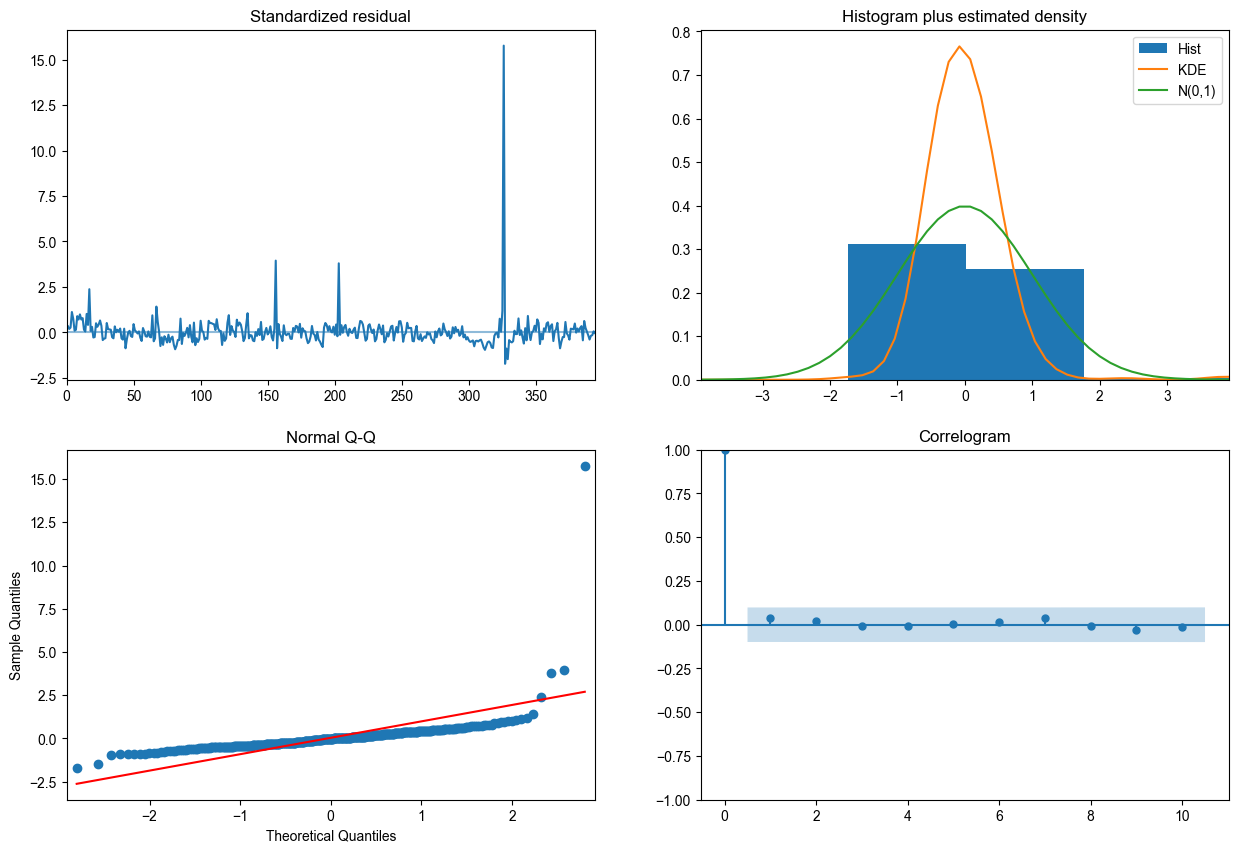

In [14]:
# 殘差診斷(原本 Auto-ARIMA 模型的)，這個只是拿來分析用，實際跑的是拿 ARIMA 的
auto_model.plot_diagnostics(figsize = (15, 10))
plt.show()

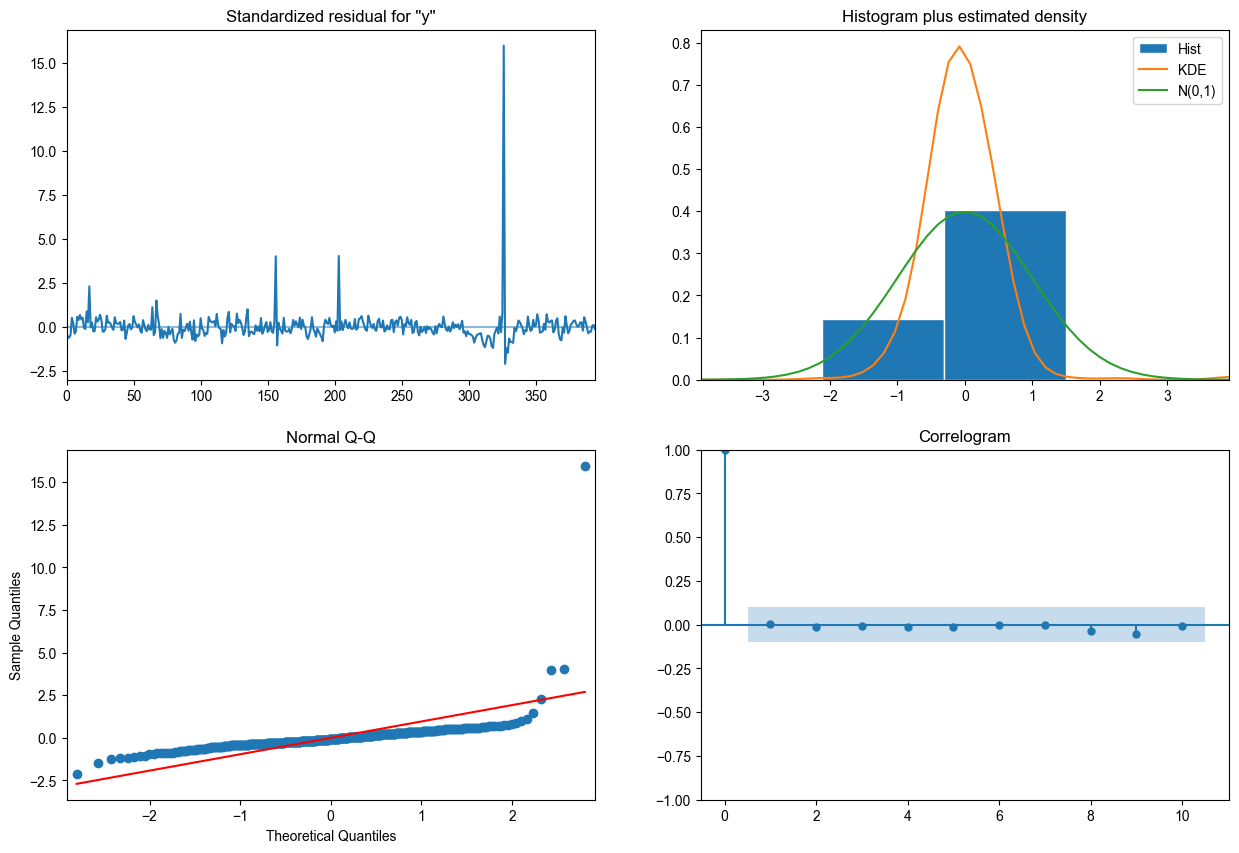

In [15]:
# 殘差診斷(原本 ARIMA 模型的)
model_summary_fit.plot_diagnostics(figsize = (15, 10))
plt.show()

## 白噪音檢定
藉由 Ljung-Box 定觀察 ARIMA 模型的殘差項是否為隨機變動，若檢定結果呈現白噪音(隨機)，則可以知道ARIMA模型的配適程度良好，便直接做預測；然而，若檢定結果呈現誤差項目並非白噪音，則需要用 `GARCH 模型找出誤差項中的變異數解釋變量`。

+ lb_stat : 這是 Ljung-Box 檢驗的檢驗統計量，用於檢查序列的自相關性，值越高表示序列具有較強的自相關性。
+ lb_pvalue : 這是對應於 Ljung-Box 統計量的 p 值，`用於檢驗零假設，即序列是白噪聲`，p 值小於 0.05（或選擇的顯著性水平）表示可以拒絕零假設，即序列可能具有顯著的自相關性，不是白噪聲。

In [16]:
lb_pvalue, white_noise_arima = arima.arima_acorr_ljungbox(arima_resid, training_window)

print('↓↓↓↓ Ljung-Box 檢驗結果 ↓↓↓↓') 
white_noise_arima

# Ljung-Box 檢驗
 H0: 誤差項為白噪音，資料是隨機的
 H1: 誤差項不是白噪音

誤差項 (P-value >= 0.05)，不能拒絕原假設(H0 成立)，殘差 "是" 白噪聲，代表殘差項目中沒有其他解釋變量可以提取，可直接使用 ARIMA 檢驗，理論上就可以停了
↓↓↓↓ Ljung-Box 檢驗結果 ↓↓↓↓


,lb_stat,lb_pvalue
14,2.828985,0.999339


## ARCH Effect 檢定

In [17]:
arch_test_result = arima.arima_het_arch(arima_resid, training_window)

# ARCH Effect 檢定
 H0: 資料中不存在 ARCH 效應
 H1: 資料中存在 ARCH 效應

殘差的方差 (P-value > 0.05)，不能拒原假設(H0 成立)，不存在顯著的 ARCH 效應，理論上就可以停了
↓↓↓↓ ARCH 檢驗結果 ↓↓↓↓
ARCH 檢驗統計量: 0.11544811965884183
p 值: 0.9999999999995971
F 統計量: 0.007924038096984401
F 統計量的 p 值: 0.9999999999996586


# 顯示預測圖表

# 顯示預測圖表


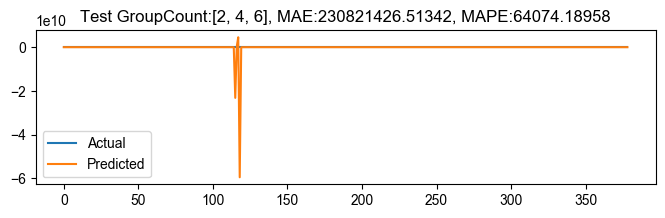

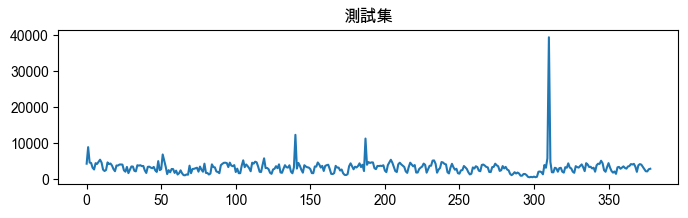

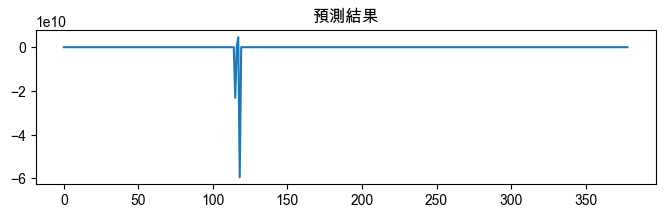

In [18]:
title = f'Test {fieldName}:{predict_types}, MAE:{round(mae, 5)}, MAPE:{round(mape, 5)}'

arima.show_predict_chart(
    eval_df,   
    actual = test_acts,
    predict = predictions,
    title = title
)

plt.figure(figsize=(8, 2))
plt.plot(test_acts, label='Actual')
plt.title('測試集')
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(predictions)
plt.title('預測結果')
plt.show()

# 儲存結果

In [19]:
arima.save_json_file(
    result_file_name, 
    label = fieldName,
    predicteds = predict_types,
    best_p = best_p,
    best_d = best_d,
    best_q = best_q,
    best_aic = best_aic,
    best_ar_pvalue = best_ar_pvalue,
    best_ma_pvalue = best_ma_pvalue,
    mae_test = mae,
    mape_test = mape, 
    mse_test = mse,
    rmse_test = rmse,
    r_square_test = r_square,
    lb_pvalue = lb_pvalue,
    arch_pvalue = arch_test_result[1]
) 

# 儲存評估結果到 JSON 檔案
{'label': 'GroupCount', 'predicteds': [2, 4, 6], 'arima_p': 13, 'arima_d': 0, 'arima_q': 6, 'aic': 7230.660172138802, 'test_mae': 230821426.51342, 'test_mape': 64074.18958, 'test_mse': 1.0816454030385277e+19, 'test_rmse': 3288837793.26152, 'test_r_square': -2094374718434.3403, 'ar_pvalue': '0.4908348367', 'ma_pvalue': '0.0000000000', 'lb_pvalue': 0.9993394117903976, 'arch_pvalue': 0.9999999999995971}
儲存評估結果到 ARIMA/_Model/GroupCount_data246.result.json
